In [3]:
%%capture
! pip install librosa
! pip install torch

In [62]:
import os
import pandas as pd
import s3fs
import zipfile
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import librosa
from scipy import signal
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.optim as optim
import torch.nn.functional as F

In [2]:
DATASET_PATH = "../data/LivingRoom_preprocessed_hack"

## Read Data

In [4]:
centroids_h1 = np.load(DATASET_PATH + "/Human1/centroid.npy")
centroids_h2 = np.load(DATASET_PATH + "/Human2/centroid.npy")
deconvoled_trim_h1 = np.load(DATASET_PATH + "/Human1/deconvoled_trim.npy")
deconvoled_trim_h2 = np.load(DATASET_PATH + "/Human2/deconvoled_trim.npy")

In [5]:
print("Deconvoled Trim Human 1 Shape: ", deconvoled_trim_h1.shape)
print("Deconvoled Trim Human 2 Shape: ", deconvoled_trim_h2.shape)
print("Centroids Huma 1 Shape: ", centroids_h1.shape)
print("Centroids Human 2 Shape: ", centroids_h2.shape)

Deconvoled Trim Human 1 Shape:  (1000, 4, 667200)
Deconvoled Trim Human 2 Shape:  (104, 4, 667200)
Centroids Huma 1 Shape:  (1000, 2)
Centroids Human 2 Shape:  (104, 2)


## Normalize Coordinates

In [6]:
def normalize_coordinates(centroids):
    x_min = -4000
    x_max = 500
    y_min = -4000
    y_max = 2000

    room_width = x_max - x_min
    room_height = y_max - y_min

    centroids[:, 0] = (centroids[:, 0] - x_min) / room_width
    centroids[:, 1] = (centroids[:, 1] - y_min) / room_height
    return centroids

centroids_h1 = normalize_coordinates(centroids_h1)
centroids_h2 = normalize_coordinates(centroids_h2)

## Human 1

In [7]:
sampling_rate = 44100
preprocessed_data_mfcc = []
preprocessed_data_rms = []
preprocessed_data_zcr = []

start_time_index = 0
end_time_index = 50000

# Wrap the outer loop with tqdm for progress visualization
for instance_index in tqdm(range(deconvoled_trim_h1.shape[0])):
    instance_data_mfcc = []
    instance_data_zcr = []
    instance_data_rms = []
    for channel_index in range(deconvoled_trim_h1.shape[1]):
        channel_signal = deconvoled_trim_h1[instance_index, channel_index, :]
        focused_signal = channel_signal[start_time_index:end_time_index+1]
        # Filtering
        filtered_signal = signal.medfilt(focused_signal, kernel_size=3)
        
        # Normalization
        normalized_signal = librosa.util.normalize(filtered_signal)

        # Resampling
        resampled_signal = librosa.resample(normalized_signal, orig_sr=sampling_rate, target_sr=16000)
        
        # Feature extraction
        # MFCC features

        # Mel spectrogram
        mel_features = librosa.feature.melspectrogram(
            y=resampled_signal,
            sr=16000,
            n_fft=2048,
            hop_length=512,
            n_mels=128
        )
        mfcc_features = librosa.feature.mfcc(S=librosa.power_to_db(mel_features))

        # RMS features
        rms_features = np.sqrt(np.mean(resampled_signal**2))
        # rms_features = librosa.feature.rms(y=normalized_signal)

        # Zero-Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=resampled_signal)
        
        instance_data_mfcc.append(mfcc_features)
        instance_data_zcr.append(zero_crossing_rate)
        instance_data_rms.append(rms_features)
    
    preprocessed_data_mfcc.append(instance_data_mfcc)
    preprocessed_data_rms.append(instance_data_rms)
    preprocessed_data_zcr.append(instance_data_zcr)

preprocessed_data_mfcc_h1 = np.array(preprocessed_data_mfcc)
preprocessed_data_rms_h1 = np.array(preprocessed_data_rms)
preprocessed_data_zcr_h1 = np.array(preprocessed_data_zcr)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:32<00:00, 30.85it/s]


## Human 2

In [8]:
sampling_rate = 44100
preprocessed_data_mfcc = []
preprocessed_data_rms = []
preprocessed_data_zcr = []

start_time_index = 0
end_time_index = 50000

# Wrap the outer loop with tqdm for progress visualization
for instance_index in tqdm(range(deconvoled_trim_h2.shape[0])):
    instance_data_mfcc = []
    instance_data_zcr = []
    instance_data_rms = []
    for channel_index in range(deconvoled_trim_h2.shape[1]):
        channel_signal = deconvoled_trim_h2[instance_index, channel_index, :]
        focused_signal = channel_signal[start_time_index:end_time_index+1]
        # Filtering
        filtered_signal = signal.medfilt(focused_signal, kernel_size=3)
        
        # Normalization
        normalized_signal = librosa.util.normalize(filtered_signal)

        # Resampling
        resampled_signal = librosa.resample(normalized_signal, orig_sr=sampling_rate, target_sr=16000)
        
        # Feature extraction
        # MFCC features

        # Mel spectrogram
        mel_features = librosa.feature.melspectrogram(
            y=resampled_signal,
            sr=16000,
            n_fft=2048,
            hop_length=512,
            n_mels=128
        )
        mfcc_features = librosa.feature.mfcc(S=librosa.power_to_db(mel_features))

        # RMS features
        rms_features = np.sqrt(np.mean(resampled_signal**2))
        # rms_features = librosa.feature.rms(y=normalized_signal)

        # Zero-Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=resampled_signal)
        
        instance_data_mfcc.append(mfcc_features)
        instance_data_zcr.append(zero_crossing_rate)
        instance_data_rms.append(rms_features)
    
    preprocessed_data_mfcc.append(instance_data_mfcc)
    preprocessed_data_rms.append(instance_data_rms)
    preprocessed_data_zcr.append(instance_data_zcr)

preprocessed_data_mfcc_h2 = np.array(preprocessed_data_mfcc)
preprocessed_data_rms_h2 = np.array(preprocessed_data_rms)
preprocessed_data_zcr_h2 = np.array(preprocessed_data_zcr)

100%|██████████| 104/104 [00:03<00:00, 29.76it/s]


In [25]:
def plot_audio_features(instance_index, channel_index=0, mfcc_features=[], rms_features=[], zero_crossing_rate=[]):
    if len(mfcc_features) > 0:
        # Plot MFCC features
        plt.figure(figsize=(10, 4))
        plt.imshow(mfcc_features, cmap='viridis', origin='lower', aspect='auto')
        plt.xlabel('Frame')
        plt.ylabel('MFCC Coefficient')
        plt.title('MFCC Features (Instance {}, Channel {})'.format(instance_index+1, channel_index+1))
        plt.colorbar(label='Magnitude')
        plt.tight_layout()
        plt.show()

    if len(rms_features) > 0:
        # Plot RMS Features for each channel
        for i, rms_channel in enumerate(rms_features):
            plt.figure(figsize=(10, 4))
            plt.plot(rms_channel, label=f'RMS Features (Channel {i+1})')
            plt.xlabel('Time (frame)')
            plt.ylabel('RMS Energy')
            plt.title('RMS Features (Instance {}, Channel {})'.format(instance_index+1, channel_index+1))
            plt.legend()
            plt.tight_layout()
            plt.show()

    if len(zero_crossing_rate) > 0:
        # Plot Zero-Crossing Rate for each channel
        for i, zcr_channel in enumerate(zero_crossing_rate):
            plt.figure(figsize=(10, 4))
            plt.plot(zcr_channel, label=f'Zero-Crossing Rate (Channel {i+1})')
            plt.xlabel('Time (frame)')
            plt.ylabel('Zero-Crossing Rate')
            plt.title('Zero-Crossing Rate (Instance {}, Channel {})'.format(instance_index+1, channel_index+1))
            plt.legend()
            plt.tight_layout()
            plt.show()

In [166]:
print("Preprocessed RMS Human 1 data: ", preprocessed_data_rms_h1.shape)
print("Preprocessed Zero-Crossing Rate Human 1 data: ", preprocessed_data_zcr_h1.shape)
print("Preprocessed MFCC Human 1 data: ", preprocessed_data_mfcc_h1.shape)
print("Preprocessed RMS Human 2 data: ", preprocessed_data_rms_h2.shape)
print("Preprocessed Zero-Crossing Rate Human 2 data: ", preprocessed_data_zcr_h2.shape)
print("Preprocessed MFCC Human 2 data: ", preprocessed_data_mfcc_h2.shape)

Preprocessed RMS Human 1 data:  (1000, 4)
Preprocessed Zero-Crossing Rate Human 1 data:  (1000, 4, 1, 36)
Preprocessed MFCC Human 1 data:  (1000, 4, 20, 36)
Preprocessed RMS Human 2 data:  (104, 4)
Preprocessed Zero-Crossing Rate Human 2 data:  (104, 4, 1, 36)
Preprocessed MFCC Human 2 data:  (104, 4, 20, 36)


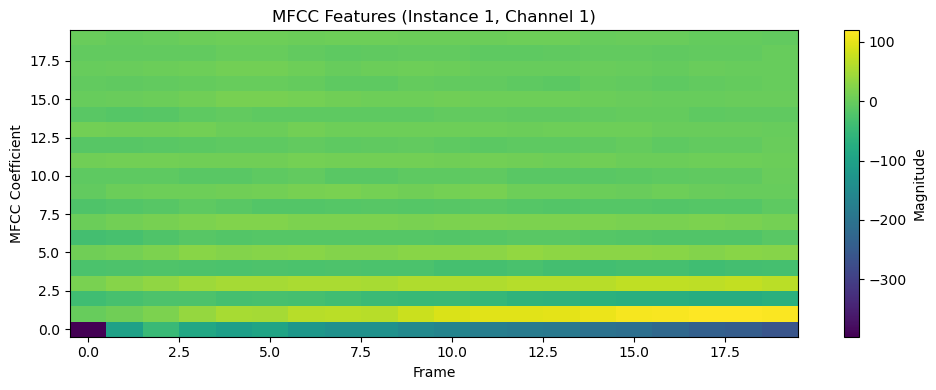

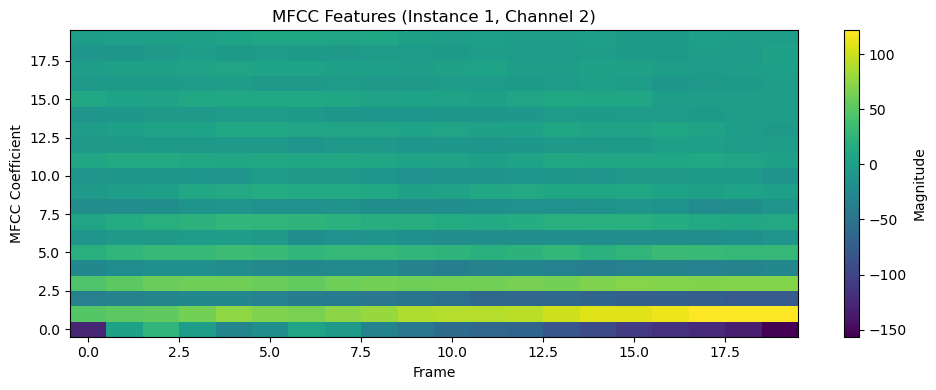

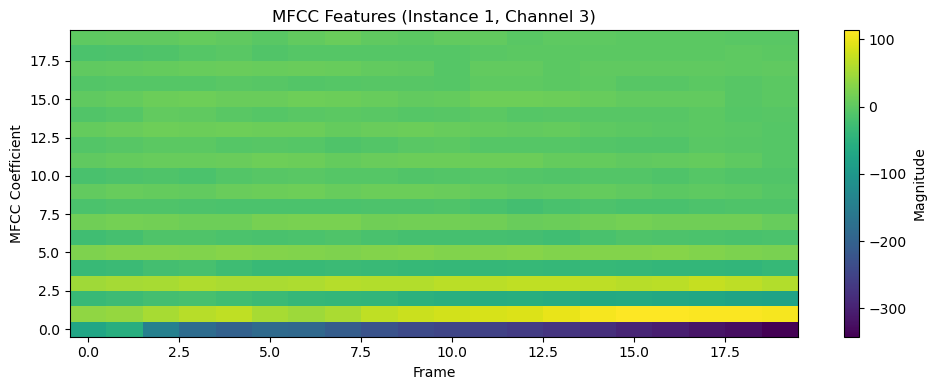

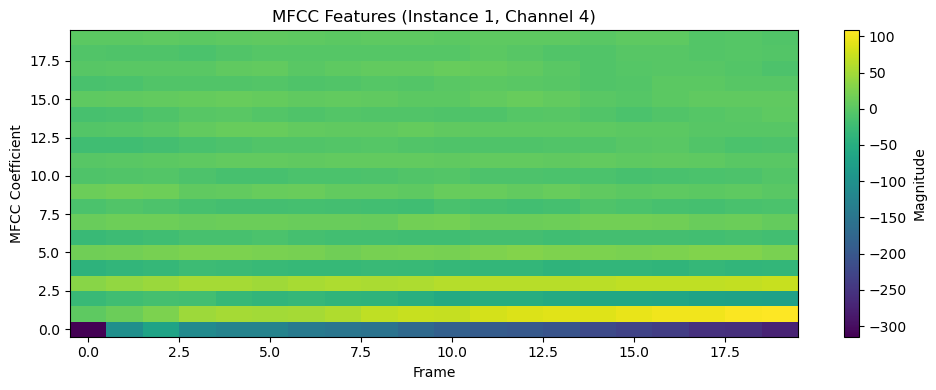

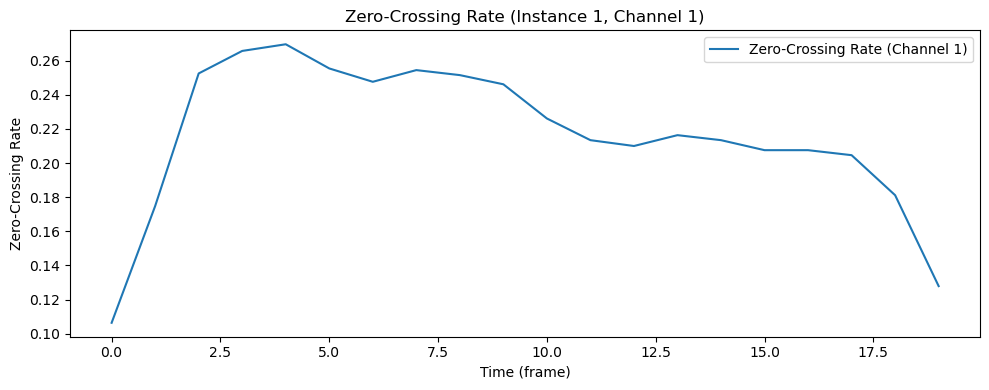

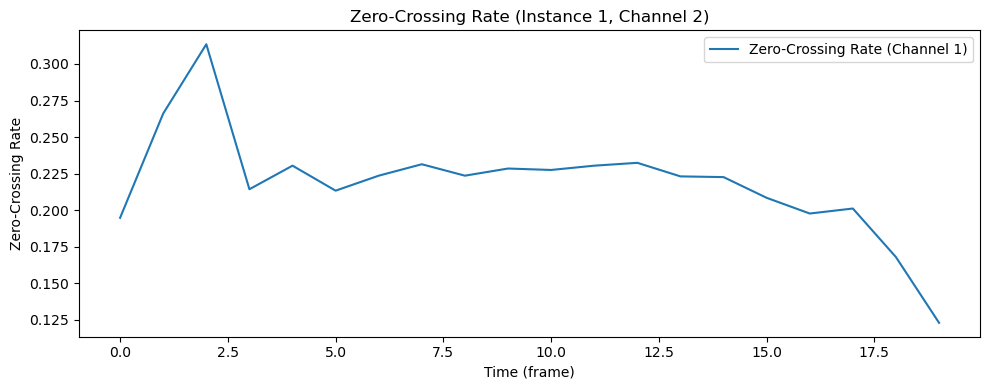

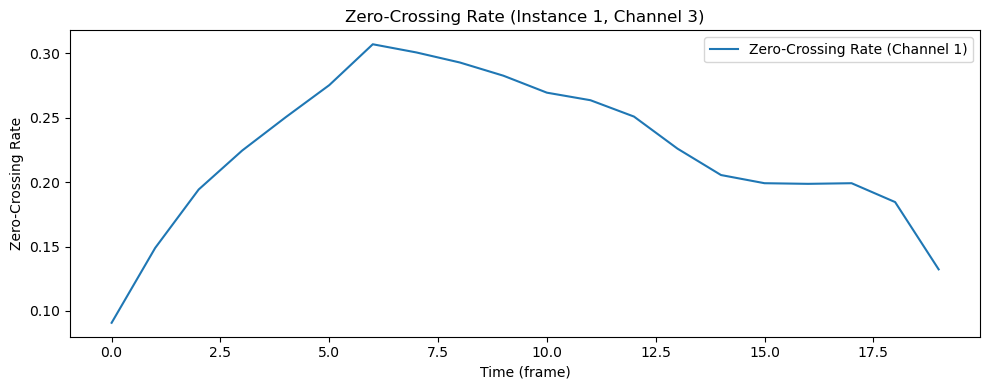

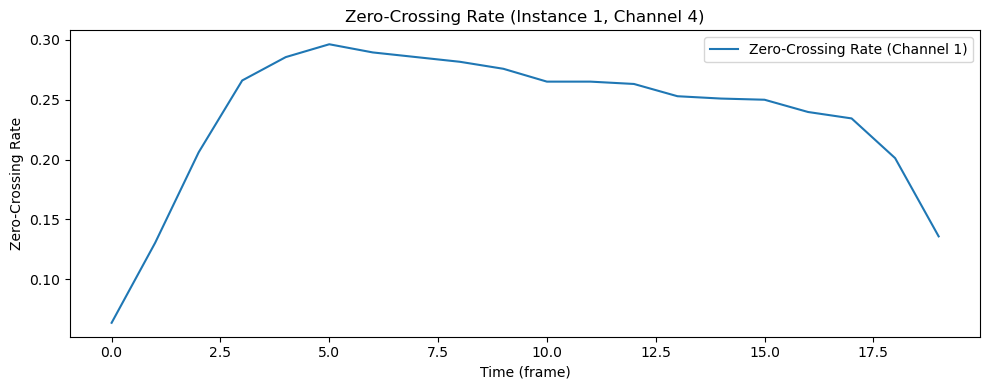

In [117]:
# Plot audio features for each instance and channel
for instance_index in range(preprocessed_data_mfcc_h2.shape[0]):
    for channel_index in range(preprocessed_data_mfcc_h2.shape[1]):
        mfcc_features = preprocessed_data_mfcc_h2[instance_index, channel_index]
        plot_audio_features(mfcc_features=mfcc_features, instance_index=instance_index, channel_index=channel_index)
    break

# Plot audio features for each instance and channel
for instance_index in range(preprocessed_data_zcr_h2.shape[0]):
    for channel_index in range(preprocessed_data_zcr_h2.shape[1]):
        zero_crossing_rate = preprocessed_data_zcr_h2[instance_index, channel_index] 
        plot_audio_features(zero_crossing_rate=zero_crossing_rate, instance_index=instance_index, channel_index=channel_index)
    break

Summed MFCC images for instance 1 in human 2 :


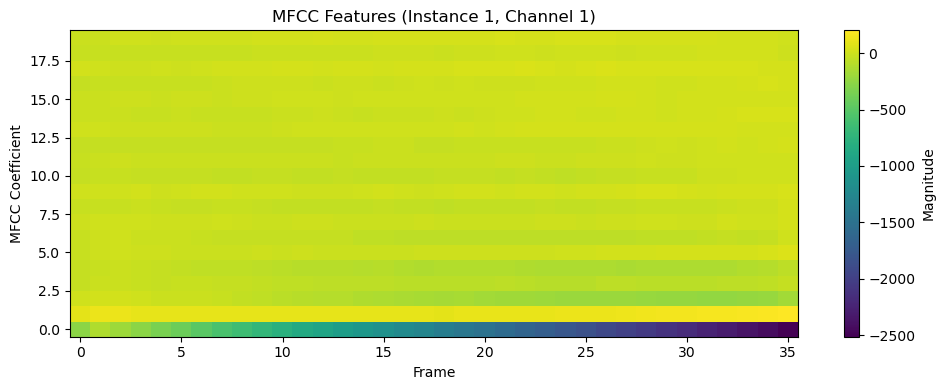

In [56]:
num_instances_h2 = preprocessed_data_mfcc_h2.shape[0]
num_channels_h2 = preprocessed_data_mfcc_h2.shape[1]
num_mfcc_h2 = preprocessed_data_mfcc_h2.shape[2]
feature_size_h2 = preprocessed_data_mfcc_h2.shape[3]

num_instances_h1 = preprocessed_data_mfcc_h1.shape[0]
num_channels_h1 = preprocessed_data_mfcc_h1.shape[1]
num_mfcc_h1 = preprocessed_data_mfcc_h1.shape[2]
feature_size_h1 = preprocessed_data_mfcc_h1.shape[3]

summed_mfcc_images_h1 = np.zeros((num_instances_h1, num_mfcc_h1, feature_size_h1))
summed_mfcc_images_h2 = np.zeros((num_instances_h2, num_mfcc_h2, feature_size_h2))

for instance_index in range(num_instances_h2):
    mfcc_images = preprocessed_data_mfcc_h2[instance_index]  # Shape: (num_channels, num_mfcc, feature_size)
    summed_mfcc_images_h2[instance_index] = np.sum(mfcc_images, axis=0)

for instance_index in range(num_instances_h1):
    mfcc_images = preprocessed_data_mfcc_h1[instance_index]  # Shape: (num_channels, num_mfcc, feature_size)
    summed_mfcc_images_h1[instance_index] = np.sum(mfcc_images, axis=0)

instance_index_to_check = 0
print("Summed MFCC images for instance", instance_index_to_check + 1, "in human 2 :")

mfcc_features_h2 = summed_mfcc_images_h2[instance_index_to_check]
plot_audio_features(mfcc_features=mfcc_features_h2, instance_index=instance_index_to_check)

## Dataset

In [63]:
class CustomDataset(Dataset):
    def __init__(self, coordinates, preprocessed_data_mfcc=[], _type="rms", preprocessed_data_rms=[], preprocessed_data_zcr=[], nb_mics=4):
        self.preprocessed_data_mfcc = preprocessed_data_mfcc
        self.preprocessed_data_rms = preprocessed_data_rms
        self.preprocessed_data_zcr = preprocessed_data_zcr
        self.coordinates = coordinates
        self.type = _type
        self.nb_mics = nb_mics
        if self.type == "rms":
            print("RMS: ", preprocessed_data_rms.shape)
        elif self.type == "zcr":
            print("ZCR: ", preprocessed_data_zcr.shape)
        elif self.type == "mfcc":
            print("MFCC: ", preprocessed_data_mfcc.shape)
        
    def __len__(self):
        return len(self.coordinates)

    def __getitem__(self, idx):
        coordinates = torch.tensor(self.coordinates[idx], dtype=torch.float32)
        if self.type == "rms":
            rms = self.preprocessed_data_rms[idx]
            rms = torch.tensor(rms, dtype=torch.float32)
            return np.array(rms), coordinates
        elif self.type == "mfcc":
            if self.nb_mics != 1:
                mfcc = [torch.tensor(self.preprocessed_data_mfcc[idx, mic_index], dtype=torch.float32) for mic_index in range(self.nb_mics)]
            elif self.nb_mics == 1:
                mfcc = torch.tensor(self.preprocessed_data_mfcc[idx], dtype=torch.float32)
            else:
                print("Error: Invalid number of mics!")
                return None, None
            return np.array(mfcc), coordinates
        elif self.type == "zcr":
            zcr = torch.tensor(self.preprocessed_data_zcr[idx], dtype=torch.float32) if self.preprocessed_data_zcr else None
            return np.array(zcr), coordinates
        else:
            print("Error type")
            return None, None

In [121]:
#dataset_h1 = CustomDataset(preprocessed_data_mfcc=torch.tensor(summed_mfcc_images_h1).unsqueeze(1), _type='mfcc', coordinates=centroids_h1, nb_mics=1)
#dataset_h2 = CustomDataset(preprocessed_data_mfcc=torch.tensor(summed_mfcc_images_h2).unsqueeze(1), _type='mfcc', coordinates=centroids_h2, nb_mics=1)

dataset_h1 = CustomDataset(preprocessed_data_mfcc=preprocessed_data_mfcc_h1, _type='mfcc', coordinates=centroids_h1)
dataset_h2 = CustomDataset(preprocessed_data_mfcc=preprocessed_data_mfcc_h2, _type='mfcc', coordinates=centroids_h2)

batch_size = 32  # Adjust batch size based on your memory constraints and training needs

# Create DataLoader instances for dataset_h1 and dataset_h2
dataloader_h1 = DataLoader(dataset_h1, batch_size=batch_size, shuffle=True)
dataloader_h2 = DataLoader(dataset_h2, batch_size=batch_size, shuffle=False)

# Access a sample from the dataset
features_list, coordinates = dataset_h1[1]
print(dataset_h1[1][0].shape)

MFCC:  (1000, 4, 20, 36)
MFCC:  (104, 4, 20, 36)
(4, 20, 36)


In [122]:
# Define your custom VGGish-like model
class VGGishMultiChannel(nn.Module):
    def __init__(self, n_channels):
        super(VGGishMultiChannel, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(3, 3), padding=(1, 1))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1))
        self.fc1 = nn.Linear(128 * 5 * 9, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=(2, 2), stride=(2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=(2, 2), stride=(2, 2))
        x = x.view(-1, 128 * 5 * 9)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [123]:
def euclidean_distance(pred_coords, true_coords):
    if not isinstance(pred_coords, np.ndarray):
        pred_coords = pred_coords.numpy()
    if not isinstance(true_coords, np.ndarray):
        pred_coords = true_coords.numpy()
    return np.sqrt(np.sum((pred_coords - true_coords)**2))

In [124]:
def euclidean_distance(pred_coords, true_coords):
    """Custom Euclidean distance loss function."""
    return torch.sqrt(torch.sum((pred_coords - true_coords)**2))

class EuclideanDistanceLoss(nn.Module):
    def __init__(self):
        super(EuclideanDistanceLoss, self).__init__()

    def forward(self, pred_coords, true_coords):
        """Compute the Euclidean distance loss."""
        return euclidean_distance(pred_coords, true_coords)

In [131]:
# Instantiate your model
model = VGGishMultiChannel(n_channels=4)

# Define loss function and optimizer
criterion = EuclideanDistanceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100  # Number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model.to(device)  
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for batch_idx, (features, coordinates) in enumerate(dataloader_h1):
        features = features.to(device)  # Move features to device
        coordinates = coordinates.to(device)  # Move coordinates to device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(features)

        # Compute loss
        loss = criterion(outputs, coordinates)
        print(outputs, coordinates)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if batch_idx % 10 == 9:  # Print every 10 batches
            print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {running_loss / 10:.4f}")
            running_loss = 0.0

print("Training finished!")


tensor([[ 0.4582, -0.1064],
        [ 0.0284, -0.1023],
        [ 0.0783,  0.1271],
        [ 0.3155, -0.1952],
        [ 0.6245, -0.3354],
        [ 0.4331, -0.3616],
        [ 0.4255, -0.0803],
        [ 0.4392, -0.1696],
        [ 0.1217, -0.2328],
        [ 0.0596,  0.1552],
        [ 0.5980, -0.4998],
        [ 0.7358, -0.7863],
        [ 0.6370, -0.4667],
        [ 0.3499,  0.1233],
        [ 0.2530, -0.1235],
        [ 0.4566, -0.4489],
        [ 0.3657, -0.6427],
        [-0.0182,  0.0778],
        [ 0.7131, -0.4077],
        [ 0.7505, -0.3074],
        [ 0.3658, -0.5024],
        [ 0.1481, -0.1343],
        [ 0.5495, -0.0174],
        [ 0.3789, -0.1556],
        [-0.0672,  0.1135],
        [ 0.5511, -0.3735],
        [ 0.1916, -0.0560],
        [ 0.1884, -0.1295],
        [ 0.4528, -0.3242],
        [ 0.1685, -0.0570],
        [ 0.2543, -0.3430],
        [ 0.1378,  0.1545]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([[0.2186, 0.3688],
        [0.8158, 0.5234],
        

In [129]:
# Assuming you have a test DataLoader named `test_dataloader`
model.eval()  # Set model to evaluation mode

test_loss = 0.0
num_samples = 0

predicted_coords = []
with torch.no_grad():
    for features, coordinates in dataloader_h2:
        features = features.to(device)
        coordinates = coordinates.to(device)

        # Forward pass
        outputs = model(features)
        predicted_coords.append(outputs)
        # Compute loss (if needed)
        loss = criterion(outputs, coordinates)
        test_loss += loss.item() * features.size(0)  # Accumulate loss

        num_samples += features.size(0)  # Accumulate number of samples

# Calculate average loss
average_test_loss = test_loss / num_samples
# Concatenate all predicted tensors along the batch dimension
predicted_coords_tensor = torch.cat(predicted_coords, dim=0)

# Convert the concatenated tensor to a numpy array
predicted_coords_np = predicted_coords_tensor.cpu().numpy()
print(f"Average Test Loss: {average_test_loss:.4f}")

Average Test Loss: 1.3703


In [130]:
model.eval()  # Set model to evaluation mode

true_coordinates = []
predicted_coordinates = []

with torch.no_grad():
    for features, coordinates in dataloader_h2:
        features = features.to(device)
        coordinates = coordinates.to(device)

        # Forward pass
        outputs = model(features)

        # Collect true and predicted coordinates
        true_coordinates.extend(coordinates.cpu().numpy())  # Assuming coordinates are in numpy arrays
        predicted_coordinates.extend(outputs.cpu().numpy())  # Assuming outputs are in numpy arrays


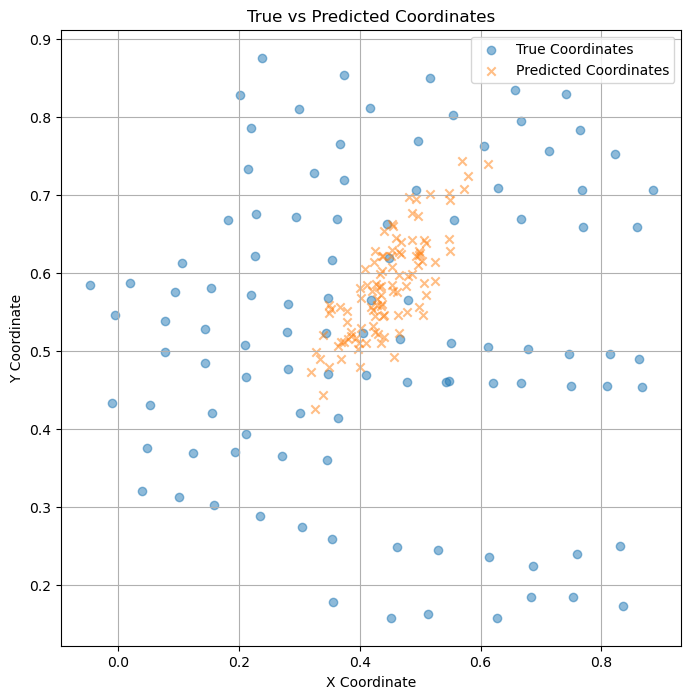

In [109]:
# Convert lists to numpy arrays
true_coordinates = np.array(true_coordinates)
predicted_coordinates = np.array(predicted_coordinates)

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(true_coordinates[:, 0], true_coordinates[:, 1], label='True Coordinates', marker='o', alpha=0.5)
plt.scatter(predicted_coordinates[:, 0], predicted_coordinates[:, 1], label='Predicted Coordinates', marker='x', alpha=0.5)
plt.title('True vs Predicted Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Convert lists to numpy arrays
true_coordinates = np.array(true_coordinates)
predicted_coordinates = np.array(predicted_coordinates)

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(true_coordinates[:, 0], true_coordinates[:, 1], label='True Coordinates', marker='o', alpha=0.5)
plt.scatter(predicted_coordinates[:, 0], predicted_coordinates[:, 1], label='Predicted Coordinates', marker='x', alpha=0.5)
plt.title('True vs Predicted Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()